In [1]:
import scanpy as sc
import episcanpy as epi
import numpy as np
import sklearn
import torch
from Fountain.data import create_dataloader,create_batchind_dict
from Fountain.fountain import Fountain
import scib
import matplotlib.pyplot as plt
import scipy
import os
import warnings
warnings.filterwarnings("ignore")

The example data for online integration can be download at [here](https://drive.google.com/file/d/1-ApKLvn9dc_Z4vE4nHJ0cFUAMTp2ra4c/view?usp=share_link).

Data preprocessing

In [2]:
adata_lung = sc.read_h5ad('lung.h5ad') 
fpeak = 0.04
epi.pp.binarize(adata_lung)
epi.pp.filter_features(adata_lung, min_cells=np.ceil(fpeak*adata_lung.shape[0]))
adata_lung.obs["cell_type"] = adata_lung.obs["celltype"].astype('category')
adata_lung.obs["batch"] = adata_lung.obs["orig.ident"].astype('category')

Obtaining batches for training

In [3]:
Train_batch=['D032', 'D032-2', 'D088', 'D150', 'D231','D122','D139']
adata_train=adata_lung[adata_lung.obs['batch'].isin(Train_batch)].copy()
adata_train.obs["batch"] = adata_train.obs["batch"].astype('category')

Model initialization and model training

In [4]:
batchind_dict=create_batchind_dict(adata_train,batch_name='batch')
batchsize=min(128*len(batchind_dict),1024)
if adata_train.shape[0]%batchsize<int(batchsize/3):
    droplast=True
else:
    droplast=False
dataloader=create_dataloader(adata_train,batch_size=batchsize,batchind_dict=batchind_dict,batch_name='batch',num_worker=4,droplast=droplast)
enc=[['fc', 1024, '', 'gelu'],['fc', 256, '', 'gelu'],['fc', 16, '', '']]
dec=[['fc', 256, '', 'gelu'],['fc', adata_train.X.shape[1], '', '']]
early_stopping= None
device='cuda:0'
model=Fountain(adata_train,enc,dec, n_domain=len(create_batchind_dict(adata_train,batch_name='batch')),batch_name='batch')

Here n_domain denotes the number of batches, and batch_name denotes the name representing batch labels in obs.

In [5]:
model.train(            
            dataloader,             
            lambda_mse=0.005, 
            lambda_Eigenvalue=0.5,
            max_iteration=30000,
            mid_iteration=3000,
            early_stopping=early_stopping,
            device=device, 
        )

Epochs: 100%|█| 477/477 [2:09:07<00:00, 16.24s/it, recon_loss=26687.507,kl_loss=


In [6]:
adata_train

AnnData object with n_obs × n_vars = 56307 × 15288
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'cell', 'UMAP1', 'UMAP2', 'celltype', 'cell_type', 'batch'
    var: 'count', 'percentile', 'var.features', 'var.features.rank', 'RNA_features', 'n_cells'
    obsm: 'X_lsi', 'X_umap'
    varm: 'LSI'
    layers: 'RNA'

Project the training bacthes to the latent space

In [7]:
batchind_dict=create_batchind_dict(adata_lung,batch_name='batch')
dataloader_whole=create_dataloader(adata_lung,batch_size=256,batchind_dict=batchind_dict,batch_name='batch',num_worker=4,droplast=False)
adata_lung.obsm['fountain']=model.get_latent(dataloader_whole,device=device)

In [8]:
sc.pp.neighbors(adata_lung,  use_rep='fountain')
sc.tl.umap(adata_lung)

2024-12-20 05:14:24.097164: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 05:14:24.303036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-20 05:14:25.525815: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
# map each cell type to a color
colors = ['#FFFF00', '#1CE6FF', '#FF34FF', '#FF4A46', '#008941', '#006FA6', '#A30059', '#FFDBE5', '#7A4900', '#0000A6',
                  '#63FFAC', '#B79762', '#004D43', '#8FB0FF', '#997D87', '#5A0007', '#809693', '#6A3A4C', '#1B4400', '#4FC601',
                  '#3B5DFF', '#4A3B53', '#FF2F80', '#61615A', '#BA0900', '#6B7900', '#00C2A0', '#FFAA92', '#FF90C9', '#B903AA',
                  '#D16100', '#DDEFFF', '#000035', '#7B4F4B', '#A1C299', '#300018', '#0AA6D8', '#013349', '#00846F', '#372101',
                  '#FFB500', '#C2FFED', '#A079BF', '#CC0744', '#C0B9B2', '#C2FF99', '#001E09']
Train=['D032', 'D032-2', 'D088', 'D150', 'D231', 'D139', 'D122']
Not_train=[ 'D046', 'D062',  'D110','D175']
cell_types = adata_lung.obs['cell_type'].unique()
batch= adata_lung.obs['batch'].unique()
color_map = dict(zip(cell_types, colors[:len(cell_types)]))
color_map2 = dict(zip(batch, colors[:len(batch)]))

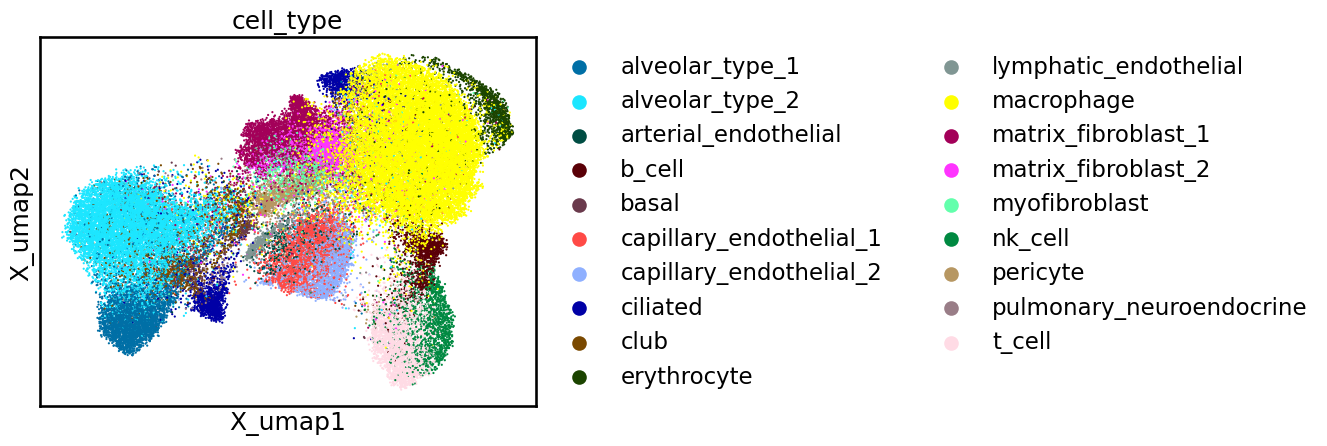

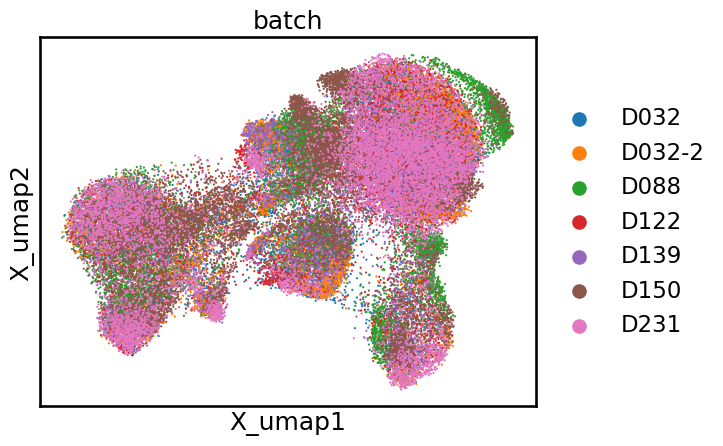

In [10]:
adata_train=adata_lung[adata_lung.obs['batch'].isin(Train_batch)]
sc.pl.embedding(adata_train, color='cell_type', basis='X_umap',   palette=color_map, size=10, 
                   legend_loc='right margin', legend_fontsize=None, legend_fontweight='bold', show=True)
sc.pl.embedding(adata_train, color='batch', basis='X_umap',   palette=None, size=10, 
                   legend_loc='right margin', legend_fontsize=None, legend_fontweight='bold', show=True)

Project new batches to the same latent space. Here we take the batch 'D064' as an example.

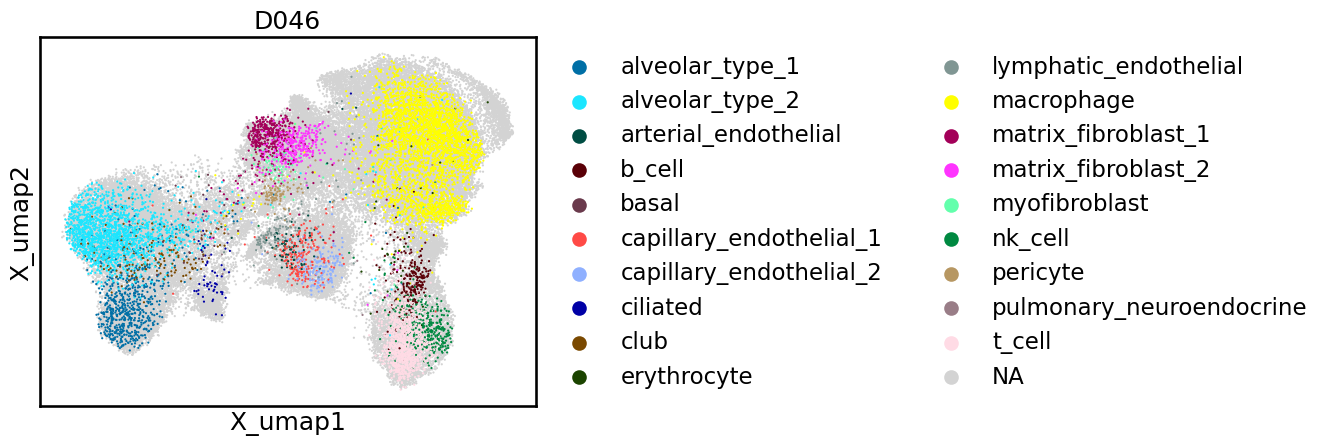

In [11]:
from Fountain.plot import embedding
project_batch='D046'
batch_list = Train.copy()
batch_list.append(project_batch)
adata_plot=adata_lung[adata_lung.obs['batch'].isin(batch_list)].copy()
embedding(
    adata_plot, 
    color='cell_type', 
    color_map=color_map, 
    groupby='batch', 
    groups=[project_batch], 
    cond2=None, 
    v2=None, 
    legend_loc='right margin', 
    legend_fontsize=None, 
    legend_fontweight='bold', 
    sep='_', 
    basis='X_umap',
    size=10,
    show=False,
)